In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
import re

from tqdm import tqdm
import time

import pydicom as dicom
import nibabel as nib
import SimpleITK as sitk
import monai

import torch
import torch.nn as nn
import torch.optim as optim

from monai.networks.nets import EfficientNetBN
from monai.networks.nets import ResNet
#from efficientnet_pytorch import EfficientNet

import wandb


In [2]:
SEED = 344
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # Fix the network according to random seed
    print('Finish seeding with seed {}'.format(seed))
    
seed_everything(SEED)
print('Training on device {}'.format(device))

Finish seeding with seed 344
Training on device cuda


In [3]:
dicom_tag_columns = [
    'Columns',
    'ImageOrientationPatient',
    'ImagePositionPatient',
    'InstanceNumber',
    'PatientID',
    'PatientPosition',
    'PixelSpacing',
    'RescaleIntercept',
    'RescaleSlope',
    'Rows',
    'SeriesNumber',
    'SliceThickness',
    'path',
    'WindowCenter',
    'WindowWidth'
]

train_dicom_tags = pd.read_parquet('autodl-tmp/train_dicom_tags.parquet', columns=dicom_tag_columns)
test_dicom_tags = pd.read_parquet('autodl-tmp/test_dicom_tags.parquet', columns=dicom_tag_columns)

train_series_meta = pd.read_csv('autodl-tmp/train_series_meta.csv')
test_series_meta = pd.read_csv('autodl-tmp/test_series_meta.csv')

train_csv = pd.read_csv('autodl-tmp/train.csv')

train_csv

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,9951,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3143,9960,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3144,9961,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3145,9980,1,0,1,0,1,0,0,1,0,0,0,0,1,1


In [4]:
def raw_path_gen(patient_id, series_id, train=True):
    if(train):
        path = 'autodl-tmp/train_images_resample/'
    else:
        path = 'autodl-tmp/train_images_resample/'
    
    path += str(patient_id) + '/' + str(series_id)
    
    return path

def create_3D_scans(folder, downsample_rate=1): 
    filenames = os.listdir(folder)
    filenames = [int(filename.split('.')[0]) for filename in filenames]
    filenames = sorted(filenames)
    filenames = [str(filename) + '.dcm' for filename in filenames]
        
    volume = []
    #for filename in tqdm(filenames[::downsample_rate], position=0): 
    for filename in filenames[::downsample_rate]: 
        filepath = os.path.join(folder, filename)
        ds = dicom.dcmread(filepath)
        image = ds.pixel_array
        
        if ds.PixelRepresentation == 1:
            bit_shift = ds.BitsAllocated - ds.BitsStored
            dtype = image.dtype 
            image = (image << bit_shift).astype(dtype) >>  bit_shift
        
        # find rescale params
        if ("RescaleIntercept" in ds) and ("RescaleSlope" in ds):
            intercept = float(ds.RescaleIntercept)
            slope = float(ds.RescaleSlope)
    
        # find clipping params
        center = int(ds.WindowCenter)
        width = int(ds.WindowWidth)
        low = center - width / 2
        high = center + width / 2    
        
        
        image = (image * slope) + intercept
        image = np.clip(image, low, high)

        image = (image / np.max(image) * 255).astype(np.int16)
        image = image[::downsample_rate, ::downsample_rate]
        volume.append( image )
    
    volume = np.stack(volume, axis=0)
    return volume

def plot_image_with_seg(volume, volume_seg=[], orientation='Coronal', num_subplots=20):
    # simply copy
    if len(volume_seg) == 0:
        plot_mask = 0
    else:
        plot_mask = 1
        
    if orientation == 'Coronal':
        slices = np.linspace(0, volume.shape[2]-1, num_subplots).astype(np.int16)
        volume = volume.transpose([1, 0, 2])
        if plot_mask:
            volume_seg = volume_seg.transpose([1, 0, 2])
        
    elif orientation == 'Sagittal':
        slices = np.linspace(0, volume.shape[2]-1, num_subplots).astype(np.int16)
        volume = volume.transpose([2, 0, 1])
        if plot_mask:
            volume_seg = volume_seg.transpose([2, 0, 1])

    elif orientation == 'Axial':
        slices = np.linspace(0, volume.shape[0]-1, num_subplots).astype(np.int16)
           
    rows = np.max( [np.floor(np.sqrt(num_subplots)).astype(int) - 2, 1])
    cols = np.ceil(num_subplots/rows).astype(int)
    
    fig, ax = plt.subplots(rows, cols, figsize=(cols * 2, rows * 4))
    fig.tight_layout(h_pad=0.01, w_pad=0)
    
    ax = ax.ravel()
    for this_ax in ax:
        this_ax.axis('off')

    for counter, this_slice in enumerate( slices ):
        plt.sca(ax[counter])
        
        image = volume[this_slice, :, :]
        plt.imshow(image, cmap='gray')
        
        if plot_mask:
            mask = np.where(volume_seg[this_slice, :, :], volume_seg[this_slice, :, :], np.nan)
            plt.imshow(mask, cmap='Set1', alpha=0.5)
            
def load_nii(patient_id, series_id, root='autodl-tmp/train_images_resample/'):
    path = root + str(patient_id) + '/' + str(series_id) + '.nii.gz'
    img = sitk.ReadImage(path)
    img = sitk.GetArrayFromImage(img)
    
    # img = nib.load(path)
    # img = img.get_fdata().transpose(2, 1, 0)
    
    return img

-153


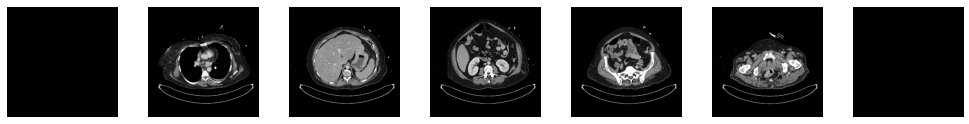

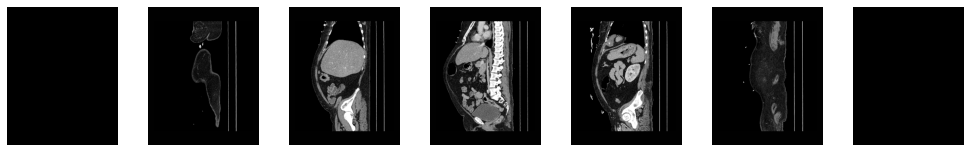

In [5]:
img_a = load_nii(10004, 21057)
print(np.min(img_a))
plot_image_with_seg(img_a, orientation='Axial', num_subplots=7)
plot_image_with_seg(img_a, orientation='Sagittal', num_subplots=7)

In [6]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CTDataset(Dataset):
    def __init__(self, root='autodl-tmp/train_images_resample/', augmentation=False, meta=train_series_meta, device='cpu'):
        self.device = device
        self.series_meta = meta
        self.root = root
        self.t = monai.transforms.Compose([#monai.transforms.NormalizeIntensity(),
                                    monai.transforms.RandRotate(range_x=3.14 / 24, prob=0.5),
                                    monai.transforms.SpatialPad(spatial_size=(176, 140, 140), mode="edge"),
                                    monai.transforms.RandSpatialCrop(roi_size=(160, 128, 128), random_size=False),
                                ])
        self.aug = augmentation
        
    def __len__(self):
        #return 1100
        return len(self.series_meta)
    
    def __getitem__(self, idx):
        

        patient_id, series_id = self.series_meta.loc[idx, ["patient_id", "series_id"]].astype('int')
        img_a = load_nii(patient_id, series_id, self.root).astype('float32')
        #img_t = torch.from_numpy(img_a).unsqueeze(0)
        #img_t = torch.from_numpy(img_a[::2, ::2, ::2]).unsqueeze(0)
        if(self.aug):
            img_t = self.t(np.expand_dims(img_a[::2, ::2, ::2], 0))
        else:
            img_t = torch.from_numpy(img_a[::2, ::2, ::2]).unsqueeze(0)
        label_columns = [
            'bowel_injury',
            'extravasation_injury',
            'kidney_low',
            'kidney_high',
            'liver_low',
            'liver_high',
            'spleen_low',
            'spleen_high',
            'any_injury'
        ]
        label_a = train_csv.loc[train_csv.patient_id == patient_id, label_columns].values[0].astype('float32')
        label_t = torch.from_numpy(label_a)
        return img_t, label_t

In [7]:
train_meta = train_series_meta[0:3600].reset_index()
val_meta = train_series_meta[3600:].reset_index()

train_ds = CTDataset(meta = train_meta, augmentation=True)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=8)

val_ds = CTDataset(meta = val_meta, augmentation=False)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=8)

In [8]:
class EffNet2_5D(nn.Module):
    def __init__(self, slices=8, feature_out=12, ch_out=9):
        super(EffNet2_5D, self).__init__()
        self.encoder_blocks = nn.Sequential()
        self.slices = slices
        for i in range(0, slices):
            self.encoder_blocks.add_module(str(i),
                                           EfficientNetBN("efficientnet-b0", pretrained=True, progress=True, spatial_dims=2, in_channels=1, num_classes=feature_out,).to(device))
        
        # self.cls = nn.Sequential(nn.Linear(slices*feature_out, 48),
        #                          nn.Linear(48, ch_out),)
        self.cls = nn.Linear(slices*feature_out, ch_out)
    def forward(self, x):
        x_f = []
        interval = x.shape[2] // (self.slices + 3)
        for i, block in enumerate(self.encoder_blocks):
            slice_idx = interval * (i + 2)
            #print(x[:, :, slice_idx, :, :].shape)
            x_f.append(block(x[:, :, slice_idx, :, :]))
        x_f = torch.cat(x_f, -1)
        #return x
        return torch.sigmoid(self.cls(x_f))

In [9]:
# net = EffNet2_5D(ch_out=9).to(device)

# imgs, labels = next(iter(train_dl))
# outputs = net(imgs.to(device))
# print(outputs)
# loss_fn = nn.BCELoss()
# print(loss_fn(outputs, labels.to(device)))

# from torchsummary import summary
# summary(net, input_size=(1, 160, 128, 128))

In [10]:
def TrainClassifer(model,trn_dl,val_dl,optimizer, scheduler=None,
                   n_eopchs=20, device='cpu'):
 
    loss_fn = nn.BCELoss(weight=torch.Tensor([2, 6, 2, 4, 2, 4, 2, 4, 12]).to(device))
    loss_fn_unweighted = nn.BCELoss()
    model.to(device)
    best_model = model
    acc_model = model
    best_val = 999.0
    best_acc = 0.0
    PATH_MODEL = 'EffNet2_5D/test1.pt'
    wandb.init(name='test1', 
               project='EffNet2_5D-test')

    for epoch in range(1, n_eopchs + 1):
        loss_train = 0.0
        model.train()
        for imgs, labels in tqdm(trn_dl, position=0):
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            #outputs = model(imgs.unsqueeze(1))
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        loss_val = 0.0
        loss_val_unweighted = 0.0
        correct_val = 0.0
        model.eval()
        for _, (imgs, labels) in enumerate(val_dl):
            imgs = imgs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(imgs)
                #outputs = model(imgs.unsqueeze(1))
                loss = loss_fn(outputs, labels)
                loss_val += loss.item()
                loss_val_unweighted += loss_fn_unweighted(outputs, labels).item()
                
        
        if (loss_val / len(val_dl)) < best_val:
            best_val = (loss_val / len(val_dl))
            best_model.load_state_dict(model.state_dict())
        if scheduler != None:
            scheduler.step()

        print('{} Eopch {}, Training Loss {}, Val Loss {}, Unweighted Loss {}'.format(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime()),
                                                                  epoch, loss_train / len(trn_dl), loss_val / len(val_dl),
                                                                                     loss_val_unweighted / len(val_dl)))
        wandb.log({'training loss': loss_train / len(trn_dl),
                  'val loss': loss_val / len(val_dl),
                  'unweighted loss': loss_val_unweighted / len(val_dl)})
    torch.save(best_model.state_dict(), PATH_MODEL)
    print('Finish training: best_val:{}'.format(best_val))
    wandb.finish()

In [ ]:
net = EffNet2_5D(feature_out=48, ch_out=9).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-3)
TrainClassifer(model=net,trn_dl=train_dl,val_dl=val_dl,optimizer=optimizer, 
               scheduler=None, n_eopchs=20, device=device)

wandb: Currently logged in as: northm (rsna2023). Use `wandb login --relogin` to force relogin


100%|██████████| 450/450 [05:21<00:00,  1.40it/s]


2023-08-27 02:02:27 Eopch 1, Training Loss 1.4789438271522521, Val Loss 1.330021992004175, Unweighted Loss 0.23586009544648712


100%|██████████| 450/450 [05:31<00:00,  1.36it/s]


2023-08-27 02:08:34 Eopch 2, Training Loss 1.3397518777185016, Val Loss 1.4377153970354752, Unweighted Loss 0.2500371419482951


100%|██████████| 450/450 [05:12<00:00,  1.44it/s]


2023-08-27 02:14:22 Eopch 3, Training Loss 1.3123576992750168, Val Loss 1.3399951445112983, Unweighted Loss 0.23141188517534475


100%|██████████| 450/450 [05:12<00:00,  1.44it/s]


2023-08-27 02:20:11 Eopch 4, Training Loss 1.3142008909251954, Val Loss 1.2910171627140732, Unweighted Loss 0.234906454470089


100%|██████████| 450/450 [05:14<00:00,  1.43it/s]


2023-08-27 02:26:02 Eopch 5, Training Loss 1.306565898127026, Val Loss 1.2617924496424284, Unweighted Loss 0.22482996018563242


100%|██████████| 450/450 [05:05<00:00,  1.48it/s]


2023-08-27 02:31:42 Eopch 6, Training Loss 1.290496938692199, Val Loss 1.245001277263216, Unweighted Loss 0.22039490820263788


100%|██████████| 450/450 [05:23<00:00,  1.39it/s]


2023-08-27 02:37:40 Eopch 7, Training Loss 1.2974109618531333, Val Loss 1.4512143006427682, Unweighted Loss 0.24784528984011506


100%|██████████| 450/450 [05:21<00:00,  1.40it/s]


2023-08-27 02:43:34 Eopch 8, Training Loss 1.2840398543410831, Val Loss 1.581453033917242, Unweighted Loss 0.27483391036822213


100%|██████████| 450/450 [05:15<00:00,  1.43it/s]


2023-08-27 02:49:26 Eopch 9, Training Loss 1.2763291866911781, Val Loss 8.178107838836505, Unweighted Loss 2.991901703446889


100%|██████████| 450/450 [05:15<00:00,  1.43it/s]


2023-08-27 02:55:16 Eopch 10, Training Loss 1.2745269699229134, Val Loss 1.2500362104649165, Unweighted Loss 0.22193924739635248


100%|██████████| 450/450 [05:12<00:00,  1.44it/s]


2023-08-27 03:01:06 Eopch 11, Training Loss 1.2669530721505482, Val Loss 1.2306499864986475, Unweighted Loss 0.2161187874756271


100%|██████████| 450/450 [05:16<00:00,  1.42it/s]


2023-08-27 03:06:58 Eopch 12, Training Loss 1.2603854163487753, Val Loss 21.204139461620247, Unweighted Loss 4.466001526914912


100%|██████████| 450/450 [05:14<00:00,  1.43it/s]


2023-08-27 03:12:48 Eopch 13, Training Loss 1.246788717938794, Val Loss 1.3667185634589023, Unweighted Loss 0.24882303443636825


 51%|█████▏    | 231/450 [02:46<02:19,  1.57it/s]